In [467]:
%pip install xgboost

In [468]:
import pandas as pd
import numpy as np
import plotly.express as px
import calendar
from datetime import datetime
import xgboost
from xgboost import XGBClassifier, plot_importance
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', 20)

In [469]:
from google.colab import drive
drive.mount('/content/gdrive')
# directory
%cd '/content/gdrive/My Drive/Oxford/ML_for_Social_Good'
# import
df = pd.read_csv("preprocessed_2.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Oxford/ML_for_Social_Good


In [470]:
# creating a variable where the divergent data points are marked as 1 and the rest as 0
df["Group_Outlier"] = df["Yield_per_Acre"]
df["Group_Outlier"] = df["Group_Outlier"] >= 5000
df["Group_Outlier"] = df["Group_Outlier"].replace({True:1,False:0})

In [471]:
df.Set.value_counts()

train    3870
test     1290
Name: Set, dtype: int64

In [472]:
df.Group_Outlier.value_counts()

0    5139
1      21
Name: Group_Outlier, dtype: int64

In [473]:
px.scatter(df, y="Yield", x="Acre", width=650, height=450, color="Group_Outlier")

In [474]:
px.box(df, x="Yield_per_Acre", width=600, height=350)

# XGBoost

In [475]:
# Duplicating outlier rows
df_outliers = df.loc[df["Group_Outlier"]==1]
df_replicated = pd.DataFrame(np.repeat(df_outliers.values, 40, axis=0))
df_replicated.columns = df.columns
df_replicated = df_replicated.apply(pd.to_numeric, errors='ignore')
df_rep = pd.concat([df.loc[df["Set"]=="train"],df_replicated],axis=0) # Keeping only the training set from the df

In [476]:
# Distribution after row duplication
df_rep.Group_Outlier.value_counts()

0    3849
1     861
Name: Group_Outlier, dtype: int64

In [477]:
# Target variable
y = df_rep["Group_Outlier"]

# Predictors
X = df_rep.drop(columns=["ID","Set","Yield","Yield_per_Acre","Group_Outlier"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [478]:
print("training set size :", X_train.shape[0], "\ntesting set size :", X_test.shape[0],
      "\nnumber of class 1 in train set: ", y_train.sum(), "\nnumber of class 1 in test set: ", y_test.sum())

training set size : 3297 
testing set size : 1413 
number of class 1 in train set:  608 
number of class 1 in test set:  253


Accuracy: 0.9979
Precision: 0.9883
Recall: 1.0


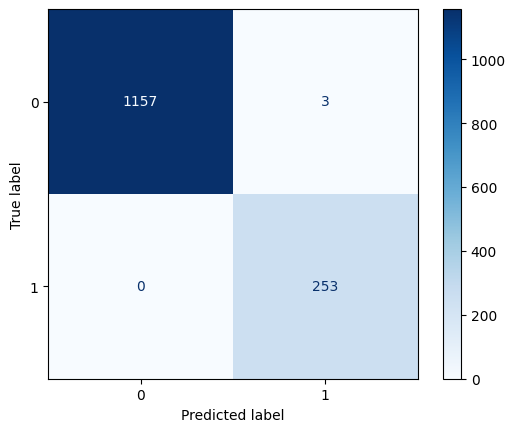

In [479]:
# RUN MODEL

xgb = XGBClassifier(random_state=0, scale_pos_weight=1, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.1, colsample_bytree=0.9, subsample=0.7, eval_metric="error",
                    importance_type='gain') # 'weight' or 'cover' or 'gain' (default)

# Train on training set
xgb.fit(X_train, y_train)

# Predictions on validation set
y_pred = xgb.predict(X_test)

# Results
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy.round(4))
precision = precision_score(y_test, y_pred)
print("Precision:", precision.round(4))
recall = recall_score(y_test, y_pred)
print("Recall:", recall.round(4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=pyplot.cm.Blues);

In [480]:
# Obtaining probabilities
testset_probabilities = xgb.predict_proba(X_test).tolist()
probabilities = pd.DataFrame(testset_probabilities)
probabilities.columns = ["Predicted_probability_0","Predicted_probability_1"]

# Merging with test set to compare the predictions with the actual results
df_results = df_rep[["ID","Set","Group_Outlier"]].reset_index().drop(columns="index")
df_results = df_results.join(probabilities,on=df_results.index)

# Quick look at probabilities
df_results.loc[df_results["Predicted_probability_0"].isnull()==False]

,ID,Set,Group_Outlier,Predicted_probability_0,Predicted_probability_1
0,ID_GTFAC7PEVWQ9,train,0,0.998825,0.001175
1,ID_TK40ARLSPOKS,train,0,0.999085,0.000915
2,ID_1FJY2CRIMLZZ,train,0,0.999700,0.000300
3,ID_I3IPXS4DB7NE,train,0,0.999446,0.000554
4,ID_4T8YQWXWHB4A,train,0,0.999721,0.000279
...,...,...,...,...,...
1408,ID_NYV8NROT8P7M,train,0,0.999691,0.000309
1409,ID_4NIM8NUGROES,train,0,0.010676,0.989324
1410,ID_X3HUOUWZLN4E,train,0,0.999484,0.000516
1411,ID_ABLBOJ0IFL1X,train,0,0.999436,0.000564


In [481]:
# Feature importance
importances = xgb.feature_importances_
test = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(10)

fig = px.bar(test, y=0, width=1000, height=450, template="ggplot2")
fig.update_layout(font=dict(size=16))
fig.show()
# I feel like it's capturing commonalities between the outliers that aren't the features that explain their increased yields

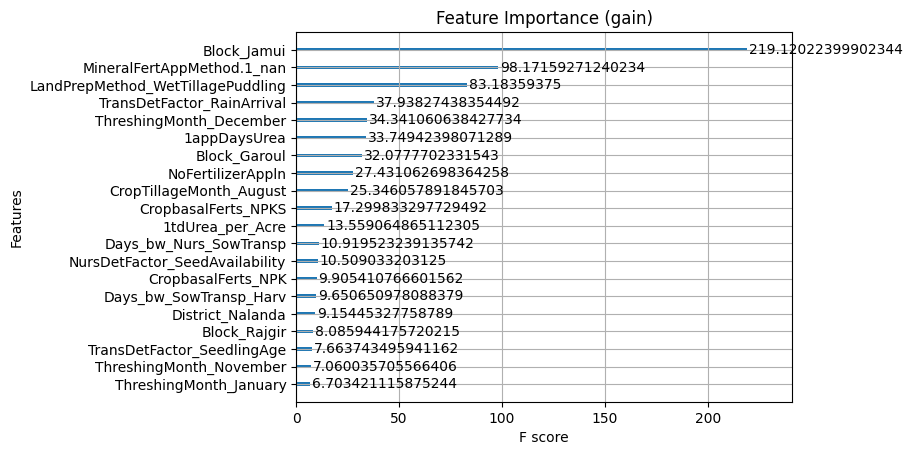

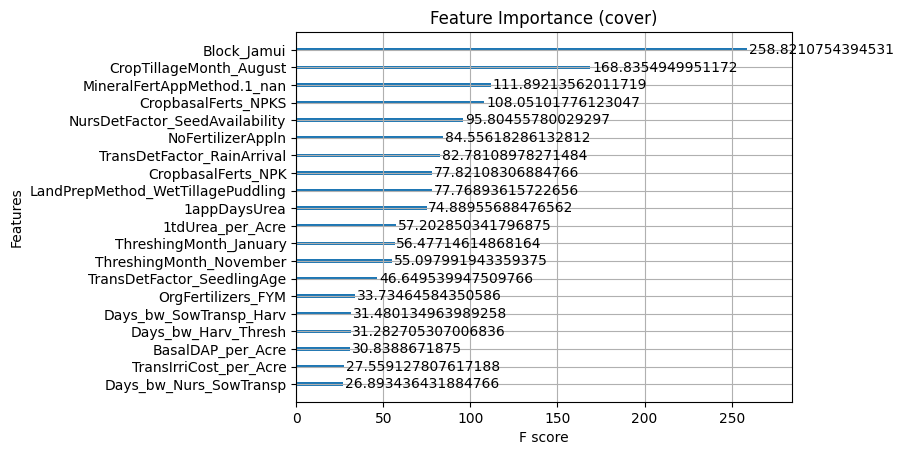

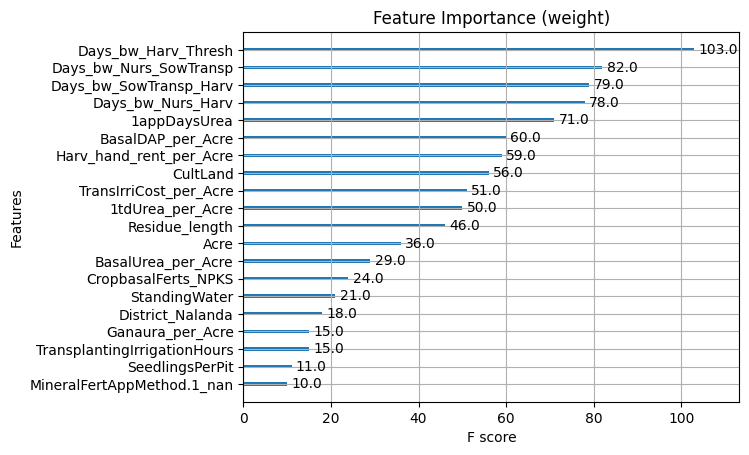

In [482]:
# Feature importance
plot_importance(xgb, max_num_features=20, importance_type = "gain", title="Feature Importance (gain)")
pyplot.show()

plot_importance(xgb, max_num_features=20, importance_type = "cover", title="Feature Importance (cover)")
pyplot.show()

plot_importance(xgb, max_num_features=20, importance_type = "weight", title="Feature Importance (weight)")
pyplot.show()

In [483]:
df.loc[df["Set"]=="test"]

,ID,Set,District_Gaya,District_Jamui,District_Nalanda,District_Vaishali,Block_Chehrakala,Block_Garoul,Block_Gurua,Block_Jamui,...,CropOrgFYM_per_Acre,BasalDAP_per_Acre,BasalUrea_per_Acre,1tdUrea_per_Acre,2tdUrea_per_Acre,Harv_hand_rent_per_Acre,TransIrriCost_per_Acre,Yield,Yield_per_Acre,Group_Outlier
3870,ID_F9XXEXN2ADR2,test,0,1,0,0,0,0,0,0,...,-0.096046,-0.616471,-0.940650,-0.318629,0.699909,-0.050424,-0.355796,NaN,NaN,0
3871,ID_SO3VW2X4QO93,test,0,1,0,0,0,0,0,0,...,-0.129628,-0.616471,-0.940650,-0.254972,1.460927,-0.460297,-0.862009,NaN,NaN,0
3872,ID_UKUQ7JM8E894,test,0,0,1,0,0,0,0,0,...,-0.129628,-0.220595,1.367624,-0.202888,-0.568455,0.799596,-0.862009,NaN,NaN,0
3873,ID_QUISMWEZR2H4,test,0,0,0,1,0,0,0,0,...,0.038282,2.867243,-0.940650,1.272798,-0.568455,0.077661,-0.862009,NaN,NaN,0
3874,ID_25JGI455VKCZ,test,0,0,1,0,0,0,0,0,...,-0.129628,1.046211,0.790555,0.491552,-0.568455,-0.690850,0.021562,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,ID_6MMECMX3B728,test,0,1,0,0,0,0,0,0,...,-0.102152,-0.537296,-0.940650,-0.463304,0.815214,0.147526,-0.585893,NaN,NaN,0
5156,ID_GZ9YGWCLLMKN,test,0,0,0,1,0,0,0,0,...,-0.003696,2.867243,-0.940650,-1.591770,-0.568455,0.173725,0.276970,NaN,NaN,0
5157,ID_01YVA2LJVYBR,test,0,0,0,1,0,1,0,0,...,0.374101,0.254457,-0.940650,0.317942,0.699909,0.846172,0.150416,NaN,NaN,0
5158,ID_YQRL2IOUU4SZ,test,0,1,0,0,0,0,0,1,...,-0.129628,-1.487400,-0.940650,-1.209828,-0.061109,-0.552518,0.656629,NaN,NaN,0


In [484]:
## Predicting on the test set, and we can see if having that as a feature improves the XGBoost regression model performance
X_TEST = df.loc[df["Set"]=="test"].drop(columns=["ID","Set","Yield","Yield_per_Acre","Group_Outlier"])

PREDS = xgb.predict(X_TEST)
PREDS.sum()

11

In [485]:
df.loc[df["Set"]=="test", "Group_Outlier"] = PREDS
df["Group_Outlier"] = df["Group_Outlier"].astype(int)

In [486]:
df.loc[(df["Set"]=="test")&(df["Group_Outlier"]==1)]

,ID,Set,District_Gaya,District_Jamui,District_Nalanda,District_Vaishali,Block_Chehrakala,Block_Garoul,Block_Gurua,Block_Jamui,...,CropOrgFYM_per_Acre,BasalDAP_per_Acre,BasalUrea_per_Acre,1tdUrea_per_Acre,2tdUrea_per_Acre,Harv_hand_rent_per_Acre,TransIrriCost_per_Acre,Yield,Yield_per_Acre,Group_Outlier
3954,ID_O2PL38IY50T5,test,0,1,0,0,0,0,0,1,...,-0.129628,0.254457,0.646288,-1.591770,-0.568455,-0.229743,5.212543,NaN,NaN,1
4044,ID_W5CLRPVGFRKH,test,0,1,0,0,0,0,0,1,...,-0.129628,0.254457,0.646288,-1.591770,-0.568455,-0.229743,5.212543,NaN,NaN,1
4169,ID_GTGEI6PS93QJ,test,0,1,0,0,0,0,0,1,...,-0.129628,-0.761626,-0.279426,-1.591770,-0.568455,-0.114467,2.934586,NaN,NaN,1
4173,ID_HBDA4P8811S8,test,0,1,0,0,0,0,0,1,...,-0.129628,-0.398739,0.051186,-1.591770,-0.568455,-0.210530,4.832884,NaN,NaN,1
4204,ID_ECWVAC40SNWB,test,0,1,0,0,0,0,0,1,...,-0.129628,-0.616471,-0.147181,-1.114342,-0.568455,-0.152892,0.352901,NaN,NaN,1
4533,ID_PVCGOZWIYCRW,test,0,1,0,0,0,0,0,1,...,-0.129628,-0.181007,0.249553,-1.114342,-0.568455,-0.152892,0.352901,NaN,NaN,1
4636,ID_NBZ50NSHWKX4,test,0,1,0,0,0,0,0,1,...,-0.129628,0.254457,0.646288,-1.591770,-0.568455,-0.383445,8.249820,NaN,NaN,1
4680,ID_2LVL6QWBY48W,test,0,1,0,0,0,0,0,1,...,-0.129628,0.351227,0.734451,-0.636914,-0.568455,-0.306594,0.319154,NaN,NaN,1
4729,ID_RUJ2JWO1H36Q,test,0,1,0,0,0,0,0,1,...,-0.129628,0.378876,0.419583,-0.636914,-0.568455,-0.141913,0.222732,NaN,NaN,1
4988,ID_BI4VNVU7JAXF,test,0,1,0,0,0,0,0,1,...,-0.129628,-1.051936,-0.543916,-1.591770,-0.568455,0.000810,1.415948,NaN,NaN,1


In [487]:
df.to_csv('preprocessed_with_outlier_classif.csv',index=False)

In [488]:
# IDs for the predicted outliers in the testing set for Models 1 (outliers duplicated x10), 2 (outliers duplicated x2) and 3 (outliers duplicated x40)
model1_ids = ["ID_W5CLRPVGFRKH","ID_HBDA4P8811S8","ID_ECWVAC40SNWB","ID_2LVL6QWBY48W","ID_RUJ2JWO1H36Q","ID_5ALLBTPE63BZ"] # model with outlier rows duplicated x10
model2_ids = ["ID_ECWVAC40SNWB","ID_PVCGOZWIYCRW","ID_RUJ2JWO1H36Q","ID_5ALLBTPE63BZ"] # model with outlier rows duplicated x2
model3_ids = ["ID_O2PL38IY50T5","ID_W5CLRPVGFRKH","ID_GTGEI6PS93QJ","ID_HBDA4P8811S8","ID_ECWVAC40SNWB","ID_PVCGOZWIYCRW","ID_NBZ50NSHWKX4","ID_2LVL6QWBY48W",
              "ID_RUJ2JWO1H36Q","ID_BI4VNVU7JAXF","ID_5ALLBTPE63BZ"] # model with outlier rows duplicated x40